In [4]:
# Initial Imports
import pandas as pd
import numpy as np
from pathlib import Path
from dotenv import load_dotenv
import time
from joblib import dump,load # Save Models
from numpy import random
import os
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt

# SDK Imports
import tweepy
import shrimpy
from newsapi import NewsApiClient
import cryptocompare

# NLP Models
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
#from ibm_watson import ToneAnalyzerV3
#from ibm_cloud_sdk.authenticators import IAMAuthenticator
# SKLearn Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
#from sklearn.preprocessing import StandardScaler, MinMaxScalar
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# Tensor Flow Models
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import LSTM, Dense, Dropout

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# HV Plot
#import hvplot.pandas
#import panel as pn

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\GrantDePalma\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [5]:
# Set environment variables from the .env file
env_path = Path("/Users/GrantDePalma")/'.env'
load_dotenv(env_path)
# Extract API Keys from environment variables
shrimpy_public_key = os.getenv("SHRIMPY_PUBLIC_KEY")
shrimpy_private_key = os.getenv("SHRIMPY_PRIVATE_KEY")
KRAKEN_API_KEY = os.getenv("KRAKEN_API_KEY")
KRAKEN_PRIVATE_KEY = os.getenv("KRAKEN_PRIVATE_KEY")

In [6]:
# Shrimpy API Client
shrimpy_client = shrimpy.ShrimpyApiClient(shrimpy_public_key, shrimpy_private_key)

In [7]:
def calc_nvt(symbol):
    # Get Into The Block blockchain data from CryptoCompare API
    url = 'https://min-api.cryptocompare.com/data/blockchain/histo/day?api_key=015b242e7bed3700ca69182009d5c7af87bf6b83f7c5a0e12eb5a9b01bee3fb0&limit=2000&fsym=' + symbol
    data = requests.get(url).json()["Data"]["Data"]
    df = pd.DataFrame(data) 
    
    # Calculate 
    df['nvt'] = df['current_supply'] / df['transaction_count'] / df['average_transaction_value']
    
    # Get pricing data from CryptoCompare API
    price_url = 'https://min-api.cryptocompare.com/data/v2/histoday?tsym=USD&limit=2000&api_key=015b242e7bed3700ca69182009d5c7af87bf6b83f7c5a0e12eb5a9b01bee3fb0&fsym=' + symbol
    histo_data = requests.get(price_url).json()["Data"]["Data"]
    
    df_price = pd.DataFrame(histo_data)
    
    combined = df.set_index('time').join(df_price.set_index('time'), on='time')
    
    return combined

def get_social(symbol):
    url = "https://min-api.cryptocompare.com/data/social/coin/histo/day?api_key=015b242e7bed3700ca69182009d5c7af87bf6b83f7c5a0e12eb5a9b01bee3fb0&limit=2000&fsym=" + symbol
    data = requests.get(url).json()[('Data')]
    df = pd.DataFrame(data)
    
    price_url = 'https://min-api.cryptocompare.com/data/v2/histoday?tsym=USD&limit=2000&api_key=015b242e7bed3700ca69182009d5c7af87bf6b83f7c5a0e12eb5a9b01bee3fb0&fsym=' + symbol
    histo_data = requests.get(price_url).json()["Data"]["Data"]
    
    df_price = pd.DataFrame(histo_data)
    
    combined = df.set_index('time').join(df_price.set_index('time'), on='time')
    return combined



In [8]:
def calc_btc_df():
    btc_df = calc_nvt('BTC')
    btc_df.reset_index(inplace = True)
    btc_df['time'] = pd.to_datetime(btc_df['time'], unit = 's')
    btc_df.drop(columns=['id', 'zero_balance_addresses_all_time', 'block_height', 'block_time', 'high', 'low', 'open', 'volumefrom', 'volumeto', 'conversionType', 'conversionSymbol'], inplace = True)
    btc_df.set_index("time", drop=True, inplace=True)
    btc_df['returns']= btc_df['close'].pct_change() 
    btc_df['sma200'] = btc_df.close.rolling(window=200).mean()
    btc_df['mayer_multiple'] = btc_df.close / btc_df.sma200
    
    quandl_mining_df = quandl.get("BITCOINWATCH/MINING", api_key=q_api)
    market_cap = pd.DataFrame(quandl_mining_df['Market Cap'])
    market_cap.reset_index(inplace=True)
    market_cap['time'] = market_cap['Date']
    market_cap.drop(columns='Date',inplace=True)
    market_cap.set_index('time', inplace=True)
        
    #mining_operating_margin = quandl.get("BCHAIN/MIOPM", api_key=q_api)
    #mining_operating_margin.columns = ['mining_op_margin']
    #mining_operating_margin.reset_index(inplace=True)
    #mining_operating_margin['time'] = mining_operating_margin['Date']
    #mining_operating_margin.drop(columns='Date', inplace=True)
    #mining_operating_margin.set_index('time', inplace=True)
    #
    fng_df = pd.DataFrame(requests.get("https://api.alternative.me/fng/?limit=0").json()['data'])
    fng_df['time'] = pd.to_datetime(fng_df['timestamp'], unit = 's')
    fng_df.set_index("time", drop=True, inplace=True)
    fng_df.sort_index(axis=0, ascending=True, inplace=True)
    fng_df.drop(columns=['time_until_update', 'timestamp', 'value_classification'], inplace = True)
    fng_df.columns = ['fng_value']
    fng_df["fng_value"] = pd.to_numeric(fng_df["fng_value"], downcast="float")
    fng_df['fng_value_1d']=fng_df['fng_value'].pct_change()
    fng_df['fng_value_3d']=fng_df['fng_value'].pct_change(3)
    fng_df['fng_value_7d']=fng_df['fng_value'].pct_change(7)
    fng_df['fng_value_sma3_1d'] = fng_df.fng_value_1d.rolling(window=3).mean()
    fng_df['fng_value_sma7_1d'] = fng_df.fng_value_1d.rolling(window=7).mean()
    fng_df.dropna(inplace=True)
    #
    social_df = get_social('BTC')
    social_df.reset_index(inplace = True)
    social_df['time'] = pd.to_datetime(social_df['time'], unit = 's')
    social_df.set_index("time", drop=True, inplace=True)
    social_df = social_df[826:-1]
    social_df = social_df.drop(columns=['high', 'low', 'open', 'volumefrom', 'volumeto', 'conversionType', 'conversionSymbol', 'close', 'analysis_page_views', 'charts_page_views', 'code_repo_closed_issues', 'code_repo_closed_pull_issues', 'code_repo_contributors', 'code_repo_forks', 'code_repo_open_issues', 'code_repo_open_pull_issues', 'code_repo_stars', 'code_repo_subscribers', 'comments', 'fb_likes', 'fb_talking_about', 'followers', 'forum_page_views', 'influence_page_views', 'markets_page_views',
       'overview_page_views', 'points', 'posts', 'reddit_subscribers', 'total_page_views', 'trades_page_views', 'twitter_favourites', 'twitter_following', 'twitter_lists'])
    social_df['reddit_active_users_incr'] = social_df.reddit_active_users.pct_change()
    social_df['reddit_comments_hr_inc'] = social_df.reddit_comments_per_hour.pct_change()
    social_df['reddit_comments_day_inc'] = social_df.reddit_comments_per_day.pct_change()
    social_df['reddit_posts_day_inc'] = social_df.reddit_posts_per_day.pct_change()
    social_df['reddit_posts_hour_inc'] = social_df.reddit_posts_per_hour.pct_change()
    social_df['twitter_followers_incr'] = social_df.twitter_followers.pct_change()
    social_df['twitter_statuses_incr'] = social_df.twitter_statuses.pct_change()
    #
    rev = quandl.get("BCHAIN/MIREV", api_key=q_api)
    rev.columns = ['miners_rev']
    rev.reset_index(inplace=True)
    rev['time'] = rev['Date']
    rev.drop(columns='Date', inplace=True)
    rev.set_index('time', inplace=True)
    #
    btc_df0 = pd.merge(btc_df, market_cap, on=['time'], how='left')
    btc_df1 = pd.merge(btc_df0, fng_df, on=['time'], how='left')
    btc_df2 = pd.merge(btc_df1, rev, on='time', how='left')
    btc_df3 = pd.merge(btc_df2, social_df, on='time', how='left')
    
    btc_df3['address_growth'] = btc_df3['new_addresses']/btc_df3['unique_addresses_all_time']
    btc_df3['perc_mined'] = btc_df3['current_supply']/21000000
    #btc_df3['price_change_1d'] = btc_df3['close'].pct_change(1)
    #btc_df3['price_change_7d'] = btc_df3['close'].pct_change(7)
    #btc_df3['price_change_30d'] = btc_df3['close'].pct_change(30)
    btc_df3.drop(columns=['block_size', 'average_transaction_value', 'difficulty', 'hashrate', 'symbol', 'sma200', 'transaction_count', 
                         'transaction_count_all_time', 'unique_addresses_all_time', 'reddit_active_users', 'twitter_followers', 'twitter_statuses', 'reddit_comments_per_day', 'reddit_comments_per_hour', 'reddit_posts_per_day', 'reddit_posts_per_hour'], inplace=True)
    btc_df3 = btc_df3.dropna()
    return btc_df3

btc_fng_df = calc_btc_df()

NameError: name 'requests' is not defined

In [ ]:
def calc_Lasso_coef_df(btc_fng_df):
    # Set feature set and drop unnecessary columns
    X = btc_fng_df.drop(columns=['close', 'returns'])
    # Set target and reshape
    y = btc_fng_df['returns'].values.reshape(-1,1)
    
    # Reserving 30% for test sample
    X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.3, random_state=31)
    
    #Initialize MinMax scaler function
    mm_scaler = MinMaxScaler()
    #X_train scaler into a DF
    X_train_mm_scaled = pd.DataFrame(mm_scaler.fit_transform(X_train),columns = X_train.columns, index = X_train.index)
    # X test scaler based on X training set
    X_mm_scaler = mm_scaler.fit(X_train)
    X_test_mm_scaled = X_mm_scaler.transform(X_test)
    #y_train scaler
    y_train_mm_scaled = mm_scaler.fit_transform(y_train)
    # y test scaler based on y training set
    y_mm_scaler = mm_scaler.fit(y_train)
    y_test_mm_scaled = y_mm_scaler.transform(y_test)
    
    lasso = Lasso(alpha=0.00005,normalize=True)
    # Fit the regressor to the data
    lasso.fit(X_train_mm_scaled,y_train_mm_scaled)
    # Compute and print the coefficients
    lasso_coef = lasso.coef_
    
    columns = X_train_mm_scaled.columns
    lasso_coef_df = pd.DataFrame(lasso_coef)
    lasso_coef_df.rename(columns={0:'lasso_coef'}, inplace=True)
    lasso_coef_df.index = columns
    lasso_coef_df['lasso_coef_abs_value'] = abs(lasso_coef_df['lasso_coef'])
    lasso_coef_df.sort_values(by=['lasso_coef_abs_value'], ascending=False, inplace=True)
    
    return lasso_coef_df

def Lasso_viz(btc_fng_df):
    # Set feature set and drop unnecessary columns
    X = btc_fng_df.drop(columns=['close', 'returns'])
    # Set target and reshape
    y = btc_fng_df['returns'].values.reshape(-1,1)
    # Reserving 30% for test sample
    X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.3, random_state=31)
    #Initialize MinMax scaler function
    mm_scaler = MinMaxScaler()
    #X_train scaler into a DF
    X_train_mm_scaled = pd.DataFrame(mm_scaler.fit_transform(X_train),columns = X_train.columns, index = X_train.index)
    # X test scaler based on X training set
    X_mm_scaler = mm_scaler.fit(X_train)
    X_test_mm_scaled = X_mm_scaler.transform(X_test)
    #y_train scaler
    y_train_mm_scaled = mm_scaler.fit_transform(y_train)
    # y test scaler based on y training set
    y_mm_scaler = mm_scaler.fit(y_train)
    y_test_mm_scaled = y_mm_scaler.transform(y_test)
    lasso = Lasso(alpha=0.00005,normalize=True)
    # Fit the regressor to the data
    lasso.fit(X_train_mm_scaled,y_train_mm_scaled)
    # Compute and print the coefficients
    lasso_coef = lasso.coef_
    
    columns = X_train_mm_scaled.columns
    lasso_coef_df = pd.DataFrame(lasso_coef)
    lasso_coef_df.rename(columns={0:'lasso_coef'}, inplace=True)
    lasso_coef_df.index = columns
    lasso_coef_df['lasso_coef_abs_value'] = abs(lasso_coef_df['lasso_coef'])
    lasso_coef_df.sort_values(by=['lasso_coef_abs_value'], ascending=False, inplace=True)
    
    print(lasso_coef)
    # Plot the coefficients
    plt.plot(range(len(X_train_mm_scaled.columns)), lasso_coef)
    plt.xticks(range(len(X_train_mm_scaled.columns)), X_train_mm_scaled.columns.values, rotation=90)
    plt.margins(0.01)
    plt.figure(figsize=(20,5))
    plt.show()
    
    lasso = Lasso()
    lasso.fit(X_train_mm_scaled,y_train_mm_scaled)
    train_score=lasso.score(X_train_mm_scaled,y_train_mm_scaled)
    test_score=lasso.score(X_test_mm_scaled,y_test_mm_scaled)
    coeff_used = np.sum(lasso.coef_!=0)
    print ("training score:", train_score)
    print ("test score: ", test_score)
    print ("number of features used: ", coeff_used)

    lasso001 = Lasso(alpha=0.01, max_iter=10e5)
    lasso001.fit(X_train_mm_scaled,y_train_mm_scaled)
    train_score001=lasso001.score(X_train_mm_scaled,y_train_mm_scaled)
    test_score001=lasso001.score(X_test_mm_scaled,y_test_mm_scaled)
    coeff_used001 = np.sum(lasso001.coef_!=0)
    print ("training score for alpha=0.01:", train_score001)
    print ("test score for alpha =0.01: ", test_score001)
    print ("number of features used: for alpha =0.01:", coeff_used001)
    lasso000001 = Lasso(alpha=0.00001, max_iter=10e5)
    lasso000001.fit(X_train_mm_scaled,y_train_mm_scaled)
    train_score000001=lasso000001.score(X_train_mm_scaled,y_train_mm_scaled)
    test_score000001=lasso000001.score(X_test_mm_scaled,y_test_mm_scaled)
    coeff_used000001 = np.sum(lasso000001.coef_!=0)
    print ("training score for alpha=0.0001:", train_score000001) 
    print ("test score for alpha =0.0001: ", test_score000001)
    print ("number of features used: for alpha =0.0001:", coeff_used000001)

    #lr = LinearRegression()
    #lr.fit(X_train_ss_scaled,y_train_ss_scaled)
    #lr_train_score=lr.score(X_train_ss_scaled,y_train_ss_scaled)
    #lr_test_score=lr.score(X_test_ss_scaled,y_test_ss_scaled)
    #print ("LR training score:", lr_train_score) 
    #print ("LR test score: ", lr_test_score)
    plt.subplot(1,2,1)
    plt.plot(lasso.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Lasso; $\alpha = 1$',zorder=7) # alpha here is for transparency
    plt.plot(lasso000001.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Lasso; $\alpha = 0.0001$') # alpha here is for transparency

    plt.xlabel('Coefficient Index',fontsize=16)
    plt.ylabel('Coefficient Magnitude',fontsize=16)
    plt.legend(fontsize=10,loc=4)
    plt.subplot(1,2,2)
    plt.plot(lasso.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Lasso; $\alpha = 1$',zorder=7) # alpha here is for transparency
    plt.plot(lasso001.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Lasso; $\alpha = 0.01$') # alpha here is for transparency
    plt.plot(lasso000001.coef_,alpha=0.8,linestyle='none',marker='v',markersize=6,color='black',label=r'Lasso; $\alpha = 0.00001$') # alpha here is for transparency
    #plt.plot(lr.coef_,alpha=0.7,linestyle='none',marker='o',markersize=5,color='green',label='Linear Regression',zorder=2)
    plt.xlabel('Coefficient Index',fontsize=16)
    plt.ylabel('Coefficient Magnitude',fontsize=16)
    plt.legend(fontsize=9, loc='best')
    plt.tight_layout()
    plt.show()

In [11]:
def calc_alt_xbt_df():
    # Fetch Assets Available on Kraken
    def get_kraken_assets():
        kraken_assets = shrimpy_client.get_exchange_assets('kraken')
        kraken_assets_df = pd.DataFrame(columns=['id','name', 'symbol', 'trading_symbol'])
        for key, value in enumerate(kraken_assets):
            kraken_assets_df.loc[key] = [value['id'], value['name'], value['symbol'], value['tradingSymbol']]
        return kraken_assets_df
    kraken_assets_df = get_kraken_assets()
    
        # Fetch Trading Pairs on Kraken
    def calc_kraken_pairs_dataframe():
        kraken_pairs = shrimpy_client.get_trading_pairs('kraken')
        kraken_pairs_df = pd.DataFrame(columns=['base','quote'])
        for key, value in enumerate(kraken_pairs):
            kraken_pairs_df.loc[key] = [value['baseTradingSymbol'],value['quoteTradingSymbol']]    
        return kraken_pairs_df

    # Create Dataframes
    kraken_pairs_df = calc_kraken_pairs_dataframe() #call function to create pairs dataframe
    kraken_usd_pairs_df = kraken_pairs_df[(kraken_pairs_df['quote']=='USD')] 
    kraken_xbt_pairs_df = kraken_pairs_df[(kraken_pairs_df['quote']=='XBT')]   
    
    #Fetch Kraken Prices
    def get_prices(kraken_pairs_df, interval, starttime):
        master_prices_df = pd.DataFrame() 
        for index, row in kraken_pairs_df.iterrows():
            candles = shrimpy_client.get_candles('kraken', row['base'], row['quote'], interval, starttime)
            time = []
            prices = []
            for key, value in enumerate(candles):
                time.append(value['time'])
                prices.append(value['close'])
            prices_df = pd.DataFrame(list(zip(time, prices)), columns = ['time', row['base']+ "_" + row['quote']])
            prices_df['time'] = pd.to_datetime(prices_df['time'])
            if master_prices_df.empty:
                master_prices_df = prices_df
            else:
                master_prices_df = pd.merge(master_prices_df, prices_df, left_on='time', right_on = 'time', how = 'left')        
        return master_prices_df
    
    # Create 1hr Price Dataframes for CryptoAssets quoted in XBT
    df_xbt_prices_1h = get_prices(kraken_xbt_pairs_df, '1h', '2016-01-01') # Call get_prices Function
    df_prices_xbt_1h = df_xbt_prices_1h.set_index('time') # set index to time
    df_prices_xbt_1h = df_prices_xbt_1h.apply(pd.to_numeric) # Convert Prices to Floats
    df_prices_xbt_1h = df_prices_xbt_1h.fillna(method='backfill') # Backfill null values
    df_prices_xbt_1h = df_prices_xbt_1h.drop(columns = ['IC_XBT', 'TR_XBT']) # Delete problem symbols

    # Create 1hr Price Dataframes for Cryptoassets quoted in USD
    #df_usd_prices_1h = get_prices(kraken_usd_pairs_df, '1h', '2016-01-01') # Call get_prices Function
    #df_prices_usd_1h = df_usd_prices_1h.set_index('time') # set index to time
    #df_prices_usd_1h = df_prices_usd_1h.apply(pd.to_numeric) # Convert Prices to Floats
    #df_prices_usd_1h = df_prices_usd_1h.fillna(method='backfill') # Backfill null values
    
    price_velocity_1h = df_prices_xbt_1h.pct_change(1)
    price_velocity_2h = df_prices_xbt_1h.pct_change(2)
    price_velocity_3h = df_prices_xbt_1h.pct_change(3)
    price_velocity_4h = df_prices_xbt_1h.pct_change(4)
    price_velocity_24h = df_prices_xbt_1h.pct_change(24)
    price_velocity_168h = df_prices_xbt_1h.pct_change(168)
    price_acceleration_1h = price_velocity_1h.pct_change(1)
    price_acceleration_2h = price_velocity_2h.pct_change(2)
    price_acceleration_3h = price_velocity_3h.pct_change(3)
    price_acceleration_4h = price_velocity_4h.pct_change(4)
    price_acceleration_24h = price_velocity_24h.pct_change(24)
    price_acceleration_168h = price_velocity_168h.pct_change(168)
    ema_9h = price_velocity_1h.ewm(halflife=9).mean()
    ema_21h = price_velocity_1h.ewm(halflife=21).mean()
    ema_crossover_long = np.where(ema_9h > ema_21h, 1.0, 0.0)
    ema_crossover_short = np.where(ema_9h < ema_21h, 1.0, 0.0)
    
    kraken_prices_1h = pd.DataFrame(price_velocity_1h.unstack())
    kraken_prices_1h.rename(columns={0: 'price_velocity_1h'}, inplace = True)
    kraken_prices_1h.reset_index(inplace=True)

    kraken_a_1h = pd.DataFrame(price_acceleration_1h.unstack())
    kraken_a_1h.rename(columns={0: 'price_acceleration_1h'}, inplace = True)
    kraken_a_1h.reset_index(inplace=True)

    kraken_prices_2h = pd.DataFrame(price_velocity_2h.unstack())
    kraken_prices_2h.rename(columns={0: 'price_velocity_2h'}, inplace = True)
    kraken_prices_2h.reset_index(inplace=True)

    kraken_a_2h = pd.DataFrame(price_acceleration_2h.unstack())
    kraken_a_2h.rename(columns={0: 'price_acceleration_2h'}, inplace = True)
    kraken_a_2h.reset_index(inplace=True)

    kraken_prices_3h = pd.DataFrame(price_velocity_3h.unstack())
    kraken_prices_3h.rename(columns={0: 'price_velocity_3h'}, inplace = True)
    kraken_prices_3h.reset_index(inplace=True)

    kraken_a_3h = pd.DataFrame(price_acceleration_3h.unstack())
    kraken_a_3h.rename(columns={0: 'price_acceleration_3h'}, inplace = True)
    kraken_a_3h.reset_index(inplace=True)

    kraken_prices_4h = pd.DataFrame(price_velocity_4h.unstack())
    kraken_prices_4h.rename(columns={0: 'price_velocity_4h'}, inplace = True)
    kraken_prices_4h.reset_index(inplace=True)

    kraken_a_4h = pd.DataFrame(price_acceleration_4h.unstack())
    kraken_a_4h.rename(columns={0: 'price_acceleration_4h'}, inplace = True)
    kraken_a_4h.reset_index(inplace=True)

    kraken_prices_24h = pd.DataFrame(price_velocity_24h.unstack())
    kraken_prices_24h.rename(columns={0: 'price_velocity_24h'}, inplace = True)
    kraken_prices_24h.reset_index(inplace=True)

    kraken_a_24h = pd.DataFrame(price_acceleration_24h.unstack())
    kraken_a_24h.rename(columns={0: 'price_acceleration_24h'}, inplace = True)
    kraken_a_24h.reset_index(inplace=True)

    kraken_prices_168h = pd.DataFrame(price_velocity_168h.unstack())
    kraken_prices_168h.rename(columns={0: 'price_velocity_168h'}, inplace = True)
    kraken_prices_168h.reset_index(inplace=True)

    kraken_a_168h = pd.DataFrame(price_acceleration_168h.unstack())
    kraken_a_168h.rename(columns={0: 'price_acceleration_168h'}, inplace = True)
    kraken_a_168h.reset_index(inplace=True)

    ema_9 = pd.DataFrame(ema_9h.unstack())
    ema_9.rename(columns={0: 'ema_9'}, inplace=True)
    ema_9.reset_index(inplace=True)

    ema_21 = pd.DataFrame(ema_21h.unstack())
    ema_21.rename(columns={0: 'ema_21'}, inplace=True)
    ema_21.reset_index(inplace=True)
    
    factor_df_1 = pd.merge(kraken_prices_1h,kraken_a_1h, on=['level_0','time'], how='left')
    factor_df_2 = pd.merge(factor_df_1,kraken_prices_2h, on=['level_0','time'], how='left')
    factor_df_3 = pd.merge(factor_df_2,kraken_a_2h, on=['level_0','time'], how='left')
    factor_df_4 = pd.merge(factor_df_3,kraken_prices_3h, on=['level_0','time'], how='left')
    factor_df_5 = pd.merge(factor_df_4,kraken_a_3h, on=['level_0','time'], how='left')
    factor_df_6 = pd.merge(factor_df_5,kraken_prices_4h, on=['level_0','time'], how='left')
    factor_df_7 = pd.merge(factor_df_6,kraken_a_4h, on=['level_0','time'], how='left')
    factor_df_8 = pd.merge(factor_df_7,kraken_prices_24h, on=['level_0','time'], how='left')
    factor_df_9 = pd.merge(factor_df_8,kraken_a_24h, on=['level_0','time'], how='left')
    factor_df_10 = pd.merge(factor_df_9,kraken_prices_168h, on=['level_0','time'], how='left')
    factor_df_11 = pd.merge(factor_df_10,kraken_a_168h, on=['level_0','time'], how='left')
    factor_df_12 = pd.merge(factor_df_11,ema_9, on=['level_0','time'], how='left')
    factor_df_13 = pd.merge(factor_df_12,ema_21, on=['level_0','time'], how='left')
    
    return factor_df_13

def calc_alt_usd_df():
    # Fetch Assets Available on Kraken
    def get_kraken_assets():
        kraken_assets = shrimpy_client.get_exchange_assets('kraken')
        kraken_assets_df = pd.DataFrame(columns=['id','name', 'symbol', 'trading_symbol'])
        for key, value in enumerate(kraken_assets):
            kraken_assets_df.loc[key] = [value['id'], value['name'], value['symbol'], value['tradingSymbol']]
        return kraken_assets_df
    kraken_assets_df = get_kraken_assets()
    
        # Fetch Trading Pairs on Kraken
    def calc_kraken_pairs_dataframe():
        kraken_pairs = shrimpy_client.get_trading_pairs('kraken')
        kraken_pairs_df = pd.DataFrame(columns=['base','quote'])
        for key, value in enumerate(kraken_pairs):
            kraken_pairs_df.loc[key] = [value['baseTradingSymbol'],value['quoteTradingSymbol']]    
        return kraken_pairs_df

    # Create Dataframes
    kraken_pairs_df = calc_kraken_pairs_dataframe() #call function to create pairs dataframe
    kraken_usd_pairs_df = kraken_pairs_df[(kraken_pairs_df['quote']=='USD')] 
    kraken_xbt_pairs_df = kraken_pairs_df[(kraken_pairs_df['quote']=='XBT')]   
    
    #Fetch Kraken Prices
    def get_prices(kraken_pairs_df, interval, starttime):
        master_prices_df = pd.DataFrame() 
        for index, row in kraken_pairs_df.iterrows():
            candles = shrimpy_client.get_candles('kraken', row['base'], row['quote'], interval, starttime)
            time = []
            prices = []
            for key, value in enumerate(candles):
                time.append(value['time'])
                prices.append(value['close'])
            prices_df = pd.DataFrame(list(zip(time, prices)), columns = ['time', row['base']+ "_" + row['quote']])
            prices_df['time'] = pd.to_datetime(prices_df['time'])
            if master_prices_df.empty:
                master_prices_df = prices_df
            else:
                master_prices_df = pd.merge(master_prices_df, prices_df, left_on='time', right_on = 'time', how = 'left')        
        return master_prices_df
    
    # Create 1hr Price Dataframes for CryptoAssets quoted in XBT
    #df_xbt_prices_1h = get_prices(kraken_xbt_pairs_df, '1h', '2016-01-01') # Call get_prices Function
    #df_prices_xbt_1h = df_xbt_prices_1h.set_index('time') # set index to time
    #df_prices_xbt_1h = df_prices_xbt_1h.apply(pd.to_numeric) # Convert Prices to Floats
    #df_prices_xbt_1h = df_prices_xbt_1h.fillna(method='backfill') # Backfill null values
    #df_prices_xbt_1h = df_prices_xbt_1h.drop(columns = ['IC_XBT', 'TR_XBT']) # Delete problem symbols

    # Create 1hr Price Dataframes for Cryptoassets quoted in USD
    df_usd_prices_1h = get_prices(kraken_usd_pairs_df, '1h', '2016-01-01') # Call get_prices Function
    df_prices_usd_1h = df_usd_prices_1h.set_index('time') # set index to time
    df_prices_usd_1h = df_prices_usd_1h.apply(pd.to_numeric) # Convert Prices to Floats
    df_prices_usd_1h = df_prices_usd_1h.fillna(method='backfill') # Backfill null values
    
    price_velocity_1h = df_prices_usd_1h.pct_change(1)
    price_velocity_2h = df_prices_usd_1h.pct_change(2)
    price_velocity_3h = df_prices_usd_1h.pct_change(3)
    price_velocity_4h = df_prices_usd_1h.pct_change(4)
    price_velocity_24h = df_prices_usd_1h.pct_change(24)
    price_velocity_168h = df_prices_usd_1h.pct_change(168)
    price_acceleration_1h = price_velocity_1h.pct_change(1)
    price_acceleration_2h = price_velocity_2h.pct_change(2)
    price_acceleration_3h = price_velocity_3h.pct_change(3)
    price_acceleration_4h = price_velocity_4h.pct_change(4)
    price_acceleration_24h = price_velocity_24h.pct_change(24)
    price_acceleration_168h = price_velocity_168h.pct_change(168)
    ema_9h = price_velocity_1h.ewm(halflife=9).mean()
    ema_21h = price_velocity_1h.ewm(halflife=21).mean()
    ema_crossover_long = np.where(ema_9h > ema_21h, 1.0, 0.0)
    ema_crossover_short = np.where(ema_9h < ema_21h, 1.0, 0.0)
    
    kraken_prices_1h = pd.DataFrame(price_velocity_1h.unstack())
    kraken_prices_1h.rename(columns={0: 'price_velocity_1h'}, inplace = True)
    kraken_prices_1h.reset_index(inplace=True)

    kraken_a_1h = pd.DataFrame(price_acceleration_1h.unstack())
    kraken_a_1h.rename(columns={0: 'price_acceleration_1h'}, inplace = True)
    kraken_a_1h.reset_index(inplace=True)

    kraken_prices_2h = pd.DataFrame(price_velocity_2h.unstack())
    kraken_prices_2h.rename(columns={0: 'price_velocity_2h'}, inplace = True)
    kraken_prices_2h.reset_index(inplace=True)

    kraken_a_2h = pd.DataFrame(price_acceleration_2h.unstack())
    kraken_a_2h.rename(columns={0: 'price_acceleration_2h'}, inplace = True)
    kraken_a_2h.reset_index(inplace=True)

    kraken_prices_3h = pd.DataFrame(price_velocity_3h.unstack())
    kraken_prices_3h.rename(columns={0: 'price_velocity_3h'}, inplace = True)
    kraken_prices_3h.reset_index(inplace=True)

    kraken_a_3h = pd.DataFrame(price_acceleration_3h.unstack())
    kraken_a_3h.rename(columns={0: 'price_acceleration_3h'}, inplace = True)
    kraken_a_3h.reset_index(inplace=True)

    kraken_prices_4h = pd.DataFrame(price_velocity_4h.unstack())
    kraken_prices_4h.rename(columns={0: 'price_velocity_4h'}, inplace = True)
    kraken_prices_4h.reset_index(inplace=True)

    kraken_a_4h = pd.DataFrame(price_acceleration_4h.unstack())
    kraken_a_4h.rename(columns={0: 'price_acceleration_4h'}, inplace = True)
    kraken_a_4h.reset_index(inplace=True)

    kraken_prices_24h = pd.DataFrame(price_velocity_24h.unstack())
    kraken_prices_24h.rename(columns={0: 'price_velocity_24h'}, inplace = True)
    kraken_prices_24h.reset_index(inplace=True)

    kraken_a_24h = pd.DataFrame(price_acceleration_24h.unstack())
    kraken_a_24h.rename(columns={0: 'price_acceleration_24h'}, inplace = True)
    kraken_a_24h.reset_index(inplace=True)

    kraken_prices_168h = pd.DataFrame(price_velocity_168h.unstack())
    kraken_prices_168h.rename(columns={0: 'price_velocity_168h'}, inplace = True)
    kraken_prices_168h.reset_index(inplace=True)

    kraken_a_168h = pd.DataFrame(price_acceleration_168h.unstack())
    kraken_a_168h.rename(columns={0: 'price_acceleration_168h'}, inplace = True)
    kraken_a_168h.reset_index(inplace=True)

    ema_9 = pd.DataFrame(ema_9h.unstack())
    ema_9.rename(columns={0: 'ema_9'}, inplace=True)
    ema_9.reset_index(inplace=True)

    ema_21 = pd.DataFrame(ema_21h.unstack())
    ema_21.rename(columns={0: 'ema_21'}, inplace=True)
    ema_21.reset_index(inplace=True)
    
    
    factor_df_1 = pd.merge(kraken_prices_1h,kraken_a_1h, on=['level_0','time'], how='left')
    factor_df_2 = pd.merge(factor_df_1,kraken_prices_2h, on=['level_0','time'], how='left')
    factor_df_3 = pd.merge(factor_df_2,kraken_a_2h, on=['level_0','time'], how='left')
    factor_df_4 = pd.merge(factor_df_3,kraken_prices_3h, on=['level_0','time'], how='left')
    factor_df_5 = pd.merge(factor_df_4,kraken_a_3h, on=['level_0','time'], how='left')
    factor_df_6 = pd.merge(factor_df_5,kraken_prices_4h, on=['level_0','time'], how='left')
    factor_df_7 = pd.merge(factor_df_6,kraken_a_4h, on=['level_0','time'], how='left')
    factor_df_8 = pd.merge(factor_df_7,kraken_prices_24h, on=['level_0','time'], how='left')
    factor_df_9 = pd.merge(factor_df_8,kraken_a_24h, on=['level_0','time'], how='left')
    factor_df_10 = pd.merge(factor_df_9,kraken_prices_168h, on=['level_0','time'], how='left')
    factor_df_11 = pd.merge(factor_df_10,kraken_a_168h, on=['level_0','time'], how='left')
    factor_df_12 = pd.merge(factor_df_11,ema_9, on=['level_0','time'], how='left')
    factor_df_13 = pd.merge(factor_df_12,ema_21, on=['level_0','time'], how='left')
    
    return factor_df_13

In [9]:
alt_usd_df = calc_alt_usd_df()

In [10]:
alt_btcusd_df = alt_usd_df[(alt_usd_df['level_0']=='XBT_USD')]
alt_btcusd_df

,level_0,time,price_velocity_1h,price_acceleration_1h,price_velocity_2h,price_acceleration_2h,price_velocity_3h,price_acceleration_3h,price_velocity_4h,price_acceleration_4h,price_velocity_24h,price_acceleration_24h,price_velocity_168h,price_acceleration_168h,ema_9,ema_21
34685,XBT_USD,2020-07-04 06:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34686,XBT_USD,2020-07-04 07:00:00+00:00,-0.000397,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.965850e-04,-0.000397
34687,XBT_USD,2020-07-04 08:00:00+00:00,0.000860,-3.167526,0.000463,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.556866e-04,0.000242
34688,XBT_USD,2020-07-04 09:00:00+00:00,-0.001398,-2.626807,-0.000540,NaN,-0.000936,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.386478e-04,-0.000323
34689,XBT_USD,2020-07-04 10:00:00+00:00,-0.000783,-0.440162,-0.002180,-5.712106,-0.001322,NaN,-0.001719,NaN,NaN,NaN,NaN,NaN,-4.628473e-04,-0.000444
34690,XBT_USD,2020-07-04 11:00:00+00:00,0.000243,-1.310102,-0.000540,0.000540,-0.001938,NaN,-0.001080,NaN,NaN,NaN,NaN,NaN,-2.991939e-04,-0.000297
34691,XBT_USD,2020-07-04 12:00:00+00:00,0.000640,1.635724,0.000883,-1.404923,0.000099,-1.105982,-0.001299,NaN,NaN,NaN,NaN,NaN,-1.110798e-04,-0.000128
34692,XBT_USD,2020-07-04 13:00:00+00:00,0.001378,1.153794,0.002019,-4.736713,0.002262,-2.710596,0.001478,NaN,NaN,NaN,NaN,NaN,1.538177e-04,0.000109
34693,XBT_USD,2020-07-04 14:00:00+00:00,-0.001024,-1.742976,0.000353,-0.600353,0.000993,-1.512357,0.001236,-1.719185,NaN,NaN,NaN,NaN,-3.598375e-05,-0.000049
34694,XBT_USD,2020-07-04 15:00:00+00:00,-0.001014,-0.009739,-0.002037,-2.008892,-0.000662,-7.666005,-0.000022,-0.979570,NaN,NaN,NaN,NaN,-1.809732e-04,-0.000171


In [12]:
alt_xbt_df = calc_alt_xbt_df()
alt_xbt_df.head()

,level_0,time,price_velocity_1h,price_acceleration_1h,price_velocity_2h,price_acceleration_2h,price_velocity_3h,price_acceleration_3h,price_velocity_4h,price_acceleration_4h,price_velocity_24h,price_acceleration_24h,price_velocity_168h,price_acceleration_168h,ema_9,ema_21
0,ADA_XBT,2020-07-04 06:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ADA_XBT,2020-07-04 07:00:00+00:00,0.005460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005460,0.005460
2,ADA_XBT,2020-07-04 08:00:00+00:00,-0.009955,-2.823379,-0.004550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002544,-0.002375
3,ADA_XBT,2020-07-04 09:00:00+00:00,0.003656,-1.367293,-0.006335,NaN,-0.00091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000316,-0.000298
4,ADA_XBT,2020-07-04 10:00:00+00:00,0.000911,-0.750911,0.004570,-2.00457,-0.00543,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.000027,0.000020


In [9]:
alt_df = calc_alt_df()

In [14]:
alt_df.head()

,level_0,time,price_velocity_1h,price_acceleration_1h,price_velocity_2h,price_acceleration_2h,price_velocity_3h,price_acceleration_3h,price_velocity_4h,price_acceleration_4h,price_velocity_24h,price_acceleration_24h,price_velocity_168h,price_acceleration_168h,ema_9,ema_21
0,ADA_XBT,2020-07-03 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ADA_XBT,2020-07-03 06:00:00+00:00,-0.000976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000976,-0.000976
2,ADA_XBT,2020-07-03 07:00:00+00:00,0.009766,-11.009766,0.008780,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004602,0.004484
3,ADA_XBT,2020-07-03 08:00:00+00:00,0.003868,-0.603868,0.013672,NaN,0.012683,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004338,0.004272
4,ADA_XBT,2020-07-03 09:00:00+00:00,-0.004817,-2.245183,-0.000967,-1.110144,0.008789,NaN,0.007805,NaN,NaN,NaN,NaN,NaN,0.001779,0.001886


In [40]:
def calc_btc_df( ):
    candles = shrimpy_client.get_candles('kraken', 'XBT', "USD",'1h', '2016-01-01')
    time = []
    prices = []
    for key, value in enumerate(candles):
        time.append(value['time'])
        prices.append(value['close'])
    prices_df = pd.DataFrame(list(zip(time, prices)), columns = ['time', 'close'])
    prices_df['time'] = pd.to_datetime(prices_df['time'])
    
    prices_df = prices_df.set_index('time') # set index to time
    prices_df['close'] = prices_df['close'].apply(pd.to_numeric) # Convert Prices to Floats
    prices_df['close'] = prices_df['close'].fillna(method='backfill') # Backfill null values
    
    prices_df['price_velocity_1h'] = prices_df['close'].pct_change(1)
    prices_df['price_velocity_2h'] = prices_df['close'].pct_change(2)
    prices_df['price_velocity_3h'] = prices_df['close'].pct_change(3)
    prices_df['price_velocity_4h'] = prices_df['close'].pct_change(4)
    prices_df['price_velocity_24h'] = prices_df['close'].pct_change(24)
    prices_df['price_velocity_168h'] = prices_df['close'].pct_change(168)
    prices_df['price_acceleration_1h'] = prices_df['price_velocity_1h'].pct_change(1)
    prices_df['price_acceleration_2h'] = prices_df['price_velocity_2h'].pct_change(2)
    prices_df['price_acceleration_3h'] = prices_df['price_velocity_3h'].pct_change(3)
    prices_df['price_acceleration_4h'] = prices_df['price_velocity_4h'].pct_change(4)
    prices_df['price_acceleration_24h'] = prices_df['price_velocity_24h'].pct_change(24)
    prices_df['price_acceleration_168h'] = prices_df['price_velocity_168h'].pct_change(168)
    prices_df['ema_9h_pct'] = prices_df['price_velocity_1h'].ewm(halflife=9).mean()
    prices_df['ema_21h_pct'] = prices_df['price_velocity_1h'].ewm(halflife=21).mean()
    prices_df['ema_9h'] = prices_df['close'].ewm(halflife=9).mean()
    prices_df['ema_21h'] = prices_df['close'].ewm(halflife=21).mean()
    prices_df['ema_crossover_long'] = np.where(prices_df['ema_9h'] > prices_df['ema_21h'], 1.0, 0.0)
    prices_df['ema_crossover_short'] = np.where(prices_df['ema_9h'] < prices_df['ema_21h'], 1.0, 0.0)
    return prices_df

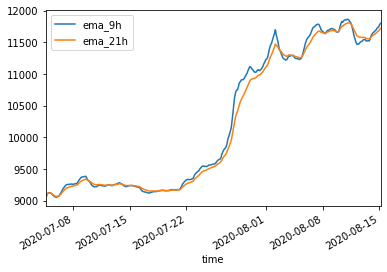

In [41]:
btc_df = calc_btc_df()
btc_df[['close','ema_9h', 'ema_21h']].plot()

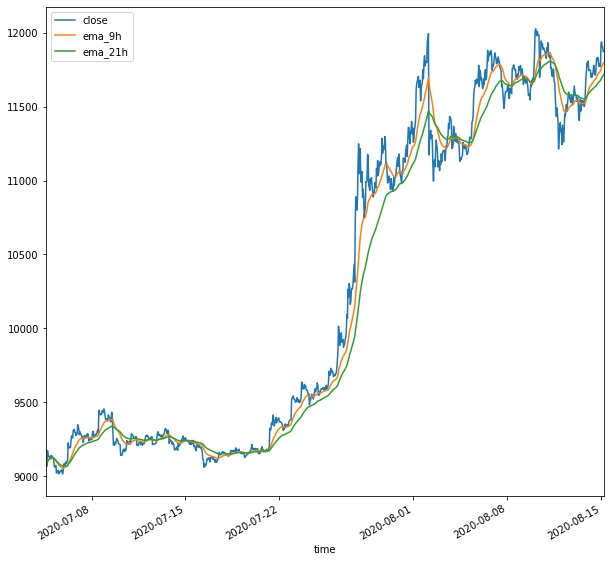

In [42]:
btc_df[['close','ema_9h', 'ema_21h']].plot(figsize=[10,10])

### need to drop infinite values and would like to add the partial differences, but maybe that just goes in areas to improve
[drop infinite values](https://stackoverflow.com/questions/17477979/dropping-infinite-values-from-dataframes-in-pandas)  

In [13]:
alt_df.isna().sum()

level_0                        0
time                           0
price_velocity_1h             33
price_acceleration_1h       3451
price_velocity_2h             66
price_acceleration_2h       2653
price_velocity_3h             99
price_acceleration_3h       2495
price_velocity_4h            132
price_acceleration_4h       2469
price_velocity_24h           792
price_acceleration_24h      3396
price_velocity_168h         5544
price_acceleration_168h    11532
ema_9                         33
ema_21                        33
dtype: int64

### LSTM
    1. Use window_data function to generate the X and y values for the model (rolling 40 hour window to predict 41 and 44 hr price change)
    2. Split the data into 7-% training and 30% testing
    3. Apply the MinMaxScaler to the X and y values
    4. Reshape the X_train and X_test data for the model

In [ ]:
def initialize():
    """Initialize the dashboard, data storage, and account balances."""
    print("Intializing Account and DataFrame")
    # Initialize Account
    account = {"balance": , "": 0}
    df = fetch_data()
    return account, df


def build_dashboard():
    """Build the dashboard."""
    loading_text = pn.widgets.StaticText(name="Trading Dashboard", value="Loading...")
    dashboard = pn.Column(loading_text)
    print("init dashboard")
    return dashboard


def update_dashboard(df, dashboard):
    """Update the dashboard."""
    dashboard[0] = df.hvplot()
    return

def fetch_data():
    """Fetches the latest prices."""
    kraken_public_key = os.getenv("KRAKEN_PUBLIC_KEY")
    kraken_secret_key = os.getenv("KRAKEN_SECRET_KEY")
    kraken = ccxt.kraken({"apiKey": kraken_public_key, "secret": kraken_secret_key})

    close = kraken.fetch_ticker("BTC/USD")["close"]
    datetime = kraken.fetch_ticker("BTC/USD")["datetime"]
    df = pd.DataFrame({"close": [close]})
    df.index = pd.to_datetime([datetime])
    return df

def select_univers():
    return asset_universe_df

def signal_generation():
    return signal_df

def target_portfolio(signal_df):
    return target_portfolio_df

def rebalance(target_portfolio, tf):
    return 

def calc_performance_metrics()
    return

def execute_backtest():
    return


def trading_algorithm(): 
    # Set environment variables from the .env file
    env_path = Path("/Users/GrantDePalma")/'.env'
    load_dotenv(env_path)
    # Extract API Keys from environment variables
    shrimpy_public_key = os.getenv("SHRIMPY_PUBLIC_KEY")
    shrimpy_private_key = os.getenv("SHRIMPY_PRIVATE_KEY")
    KRAKEN_API_KEY = os.getenv("KRAKEN_API_KEY")
    KRAKEN_PRIVATE_KEY = os.getenv("KRAKEN_PRIVATE_KEY")

    # Create User ID
    users = client.list_users()
    user_id = users[0]['id']

    # Exchange Data
    exchange_name = 'kraken'
    exchange_public_key = KRAKEN_API_KEY
    exchange_secret_key = KRAKEN_SECRET_KEY
    # Link kraken exchange 
    link_account_response = client.link_account(user_id,
                                               exchange_name,
                                               exchange_public_key,
                                               exchange_secret_key)
    account_id = link_account_response['id']

    #balances
    balance = client.get_balance(user_id, account_id)
    total_balance_history = client.get_total_balance_history(user_id, account_id)
    
    btc_wts = []
    usd_wts = [0,.25,.5]
    alt_wts = [0,.25,.5]
    
    very_bullish = # if btc price prediction is greater than 
    bullish =  # if btc
    nuetral =  # if btc is predicting 0 returns
    bearish =  # if btc is predicting negative returns
    very_bearish = # if btci predicting very negative returns
    
    if very_bullish: #>5%
        btc_wt = .5
        usd_wt = 0
        alt_wt = .5
        
    elif bullish: #0->5%
        btc_wt = .4
        usd_wt = .2
        alt_wt = .4
        
    elif nuetral: #-1% --> 0%
        btc_wt = .2
        usd_wt = .6
        alt_wt = .2
        
    elif bearish: # -5% ---> -1%
        btc_wt = .1
        usd_wt = .8
        alt_wt = .1
    
    elif very_bearish:  # < -5%
        btc_wt = 0 
        usd_wt = 1
        alt_wt = 0
    
         
    # Asset Management
    def strategy():
        if signal_df['ema_4h_cross']==1:
            wts_main = [0,.5, .5]
            alt_wts = [.5,.5] #
            if signal_df['ema_1hr_cross']==1:
                alt_wts_1 = [0,1]
                alt_wts_2 = [.1,.1,.1,.1,.1,.1,.1,.1,.1,.1]
                #alt_wts_3 = [.1,.1,.1,.1,.1,.1,.1,.1,.1,.1]
                
                wt_btc = wts_main[1] + alt_wts_1[1]*alt_wts[0] 
                wt_usd = wts_main[0] + alt_wts_1[0]*alt_wts[0]
                #alt_wts_2_ = alt_wts[1]*alt_wts_2
                #alt_wts_3_ = alt_wts[2]*alt_wts_3
                #alt_symbols = signal_df['acceleration_rank_15m'].iloc[:10]
                shrimpy_client.set_strategy(usder_id, account_id, {
                    "insDynamic":false,
                    "allocations": [
                        {"symbol": "XBT", "percent": wts_main[1]*alt_wts_1[1]},
                        {"symbol": "USD", "percent": alt_wts[0]},
                       #{"symbol": alt_symbol[0], "percent": alt_wts_2[0]},
                       #{"symbol": alt_symbol[1], "percent": alt_wts_2[1]},
                       #{"symbol": alt_symbol[2], "percent": alt_wts_3}[2],
                       #{"symbol": alt_symbol[3], "percent": alt_wts_4}[3],
                       #{"symbol": alt_symbol[4], "percent": alt_wts_5}[4],
                       #{"symbol": alt_symbol[5], "percent": alt_wts_6}[5],
                       #{"symbol": alt_symbol[6], "percent": alt_wts_7}[6],
                       #{"symbol": alt_symbol[7], "percent": alt_wts_8}[7],
                       #{"symbol": alt_symbol[8], "percent": alt_wts_9}[8],
                       #{"symbol": alt_symbol[9], "percent": alt_wts_10[9]},
                    ]
            })
            if signal_df['ema_1hr_cross']==0:
                alt_wts_1 = [.5,.5]
                alt_wts_2 = [.1,.1,.1,.1,.1,.1,.1,.1,.1,.1]
                alt_wts_3 = [.1,.1,.1,.1,.1,.1,.1,.1,.1,.1]
                
        if signal_df['ema_4hr_cross']==0:
            wts_main = [.5,.25,.25]
            alt_wts = [.5,.25,.25]
            if signal_df['ema_1hr_cross']==1:
                alt_wts_1 = [0,1]
                alt_wts_2 = [.1,.1,.1,.1,.1,.1,.1,.1,.1,.1]
                alt_wts_3 = [.1,.1,.1,.1,.1,.1,.1,.1,.1,.1]
            if signal_df['ema_1hr_cross']==0:
                alt_wts_1 = [.5,.5]
                alt_wts_2 = [.1,.1,.1,.1,.1,.1,.1,.1,.1,.1]
                alt_wts_3 = [.1,.1,.1,.1,.1,.1,.1,.1,.1,.1]            
                
                
        shrimpy_client.set_rebalance_period(user_id, account_id, 1) # set rebalance every 1 hour
        shrimpy_client.set_strategy(user_id, account_id, {
            "isDynamic":false,
            "allocations": [
                {"symbol": "XBT", "percent":btc_wt},
                {"symbol": "USD", "percent":usd_wt},
                {"symbol": alt_1, "percent": alt_wt_1},
                {"symbol": alt_2, "percent": alt_wt_2},
                {"symbol": alt_3, "percent": alt_wt_3},
                {"symbol": alt_4, "percent": alt_wt_4},
                {"symbol": alt_5, "percent": alt_wt_5},
                {"symbol": alt_6, "percent": alt_wt_6},
                {"symbol": alt_7, "percent": alt_wt_7},
                {"symbol": alt_8, "percent": alt_wt_8},
                {"symbol": alt_9, "percent": alt_wt_9},
                {"symbol": alt_10, "percent": alt_wt_10},
            ]
        })
        shrimpy_client.rebalance(user_id, account_id) # Rebalance, put in rebal
    
    
    # sell every asset besides the consolidation asset
    for asset in holdings:
        asset_symbol = asset['symbol']
        asset_amount = asset['nativeValue']
        if asset_symbol != consolidation_symbol:
            print('Selling ' + str(asset_amount) + ' of ' + asset_symbol)
            create_trade_response = client.create_trade(
                user_id,
                account_id,
                asset_symbol,
                consolidation_symbol,
                asset_amount
            )
            
    
            
            
            
# Live data feed